We assume the images are located in the the `images` folder, itself located at the root folder of the project.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from templatematching.data_generation import make_circle
from templatematching.orientation_transformer import OrientationScoreTransformer

In [17]:
# these parameters take ~1 minute to fit to have a nice visualisation, 
# scale down the size of the image/the patch to increase speed.
img = make_circle(501)
transformer = OrientationScoreTransformer(patch_size=51, num_slices=50)
transformer.fit(img)
val = transformer.transform(img)

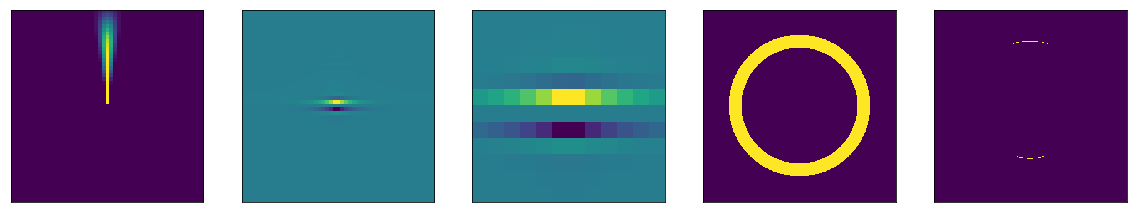

In [18]:
f, axs = plt.subplots(ncols=5, figsize=(20, 5))
for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
axs[0].matshow(transformer._cake_slices[0])
axs[1].matshow(transformer._wavelets[0].imag)

# zoom a little bit on the wavelet
zoomed_slice = slice(int(3*transformer.patch_size/8),int(5*transformer.patch_size/8))

axs[2].matshow(transformer._wavelets[0].imag[zoomed_slice, zoomed_slice])
axs[3].matshow(img)
axs[4].matshow(val[:, :, 0]>100)

In [19]:
import ipyvolume
ipyvolume.quickvolshow(150*(val>80),level=[150], level_width=[10])

In [4]:
import os
import os.path
from utils import read_norm_img
import pickle

In [5]:
def transform_img_and_dump(i):
    SE2_IMAGES_PATH='../images_transformed_se2/'
    filename = f'{i:04}.jpg'
    img = read_norm_img(i)
    transformer = OrientationScoreTransformer(patch_size=51, num_slices=12)
    transformed_img = transformer.fit_transform(img)
    with open(os.path.join(SE2_IMAGES_PATH, filename), 'wb') as fh:
        pickle.dump(transformed_img, fh)

In [26]:
from joblib import Parallel, delayed

SE2_IMAGES_PATH='../images_transformed_se2/'

if not os.path.exists(SE2_IMAGES_PATH):
    os.makedirs(SE2_IMAGES_PATH)
    
Parallel(verbose=5, n_jobs=-1, backend='threading')(delayed(transform_img_and_dump)(i) for i in range(713, 1521))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


In [8]:

with open('../images_transformed_se2/0720.jpg', 'rb') as f:
    img = pickle.load(f)

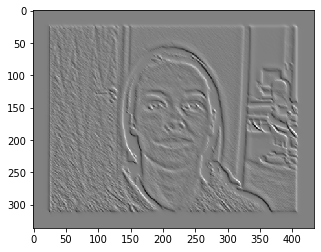

In [9]:
plt.imshow(img[:, :, 3], cmap='gray')

## Convert to jpg for disk space handling

In [10]:
PATH = '../images_transformed_se2/'

files = os.listdir(PATH)

for file in files: 
    with open(PATH + file, 'rb') as f: 
     
        img = pickle.load(f) 
        if not os.path.exists('../images_s2/' + file.rstrip('.jpg')):  
            os.makedirs('../images_s2/' + file.rstrip('.jpg')) 
        for i in range(12): 
            im = img[:, :, i] 
            plt.imsave('../images_s2/' + file.rstrip('.jpg') + '/' + '{00:02}.jpg'.format(i), im) 